In [17]:
import numpy as np
from util import load_hypocenters, PuuOo, load_puuoo_eqs
from matplotlib import pyplot as plt
import datetime
from sklearn import ensemble as ml_models
import random
%matplotlib inline

#  PuuOo Data uploading data

In [18]:
eruption_csv_path = 'PuuOo.csv'
eq_csv_path       = 'puuoo_earthquakes.csv' 

p = PuuOo(eruption_csv_path)
time, lat, lon, depth, mag = load_puuoo_eqs(eq_csv_path)
print(time[1], lon.shape)

1983-01-01 00:43:33 (6485,)


In [19]:
# Try some random times. Was PuuOo erupting?
print(time[1000], p.was_erupting(time[1000]))
print(p.was_erupting(time[680]))

# Special case for time < time of first eruption
print('\nSpecial case:')
print(p.was_erupting(time[0]))
p.was_erupting(time[0], verbose=True)

1983-05-26 07:07:49 False
True

Special case:
False
Time 1983-01-01 00:18:51 is before eruption history begins


False

### Remove eqs that happened before eruption history

In [20]:
print(len(time))


6485


In [21]:
# Make additional array for erupting or not
erupt = np.array([p.was_erupting(t) for t in time])
erupt.shape

(6485,)

### Plot some things

In [22]:
np.sum(erupt==True)

np.int64(1236)

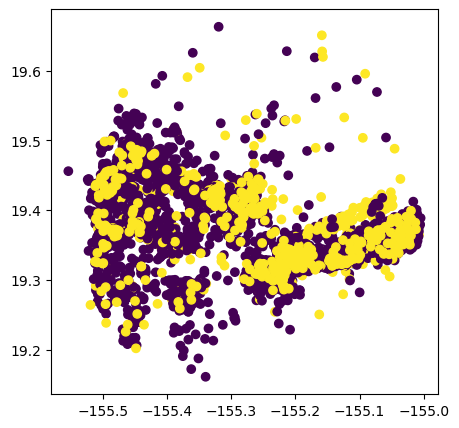

In [23]:
# Geographic distribution
c = [1 if val==True else 0 for val in erupt]
plt.figure(figsize=(5,5))
plt.scatter(lon, lat, c=c)
plt.show()

## Machine Learning!
Here's how to run random forest. So easy!! My suspicion is that this model is overfitting the training set, but we need to construct a validation/test set to really know.

### Can we get the same performance without time?

In [24]:
X = np.vstack((lat, lon, depth, mag)).T
Y = np.array([1 if val==True else 0 for val in erupt])
print(X.shape)
print(Y.shape)

(6485, 4)
(6485,)


In [25]:
#Get earthquake rates
import util
EQsLastDay, EQsLastWeek, EQsLastMonth = util.GetEQRates(time)
np.shape(X)
np.shape(EQsLastMonth)

(6485,)

The random forest method is tried here with added features

In [26]:
#Add the columns for earthquake rate
X = np.column_stack((X, EQsLastMonth))
X = np.column_stack((X, EQsLastWeek))
X = np.column_stack((X, EQsLastDay))
print(np.shape(X))

(6485, 7)


In [27]:
# Select East Rift Zone earthquakes by longitude and latitude bounds
# Example: East Rift Zone is typically between lat 19.3-19.5 and lon -155.1 to -155.0
def get_east_rift_zone_indices(lat, lon):
    # Adjust these bounds as needed for your dataset
    lat_bounds = (19.3, 19.5)
    lon_bounds = (-155.1, -155.0)
    return np.where((lat >= lat_bounds[0]) & (lat <= lat_bounds[1]) & (lon >= lon_bounds[0]) & (lon <= lon_bounds[1]))[0]

from sklearn.preprocessing import StandardScaler
np.random.seed(42)
random.seed(42)

time_to_eruption = util.GetTimeToEruption(time, p)
inds = get_east_rift_zone_indices(lat, lon)
rift_zone_data = X[inds, :]
rift_zone_labels = Y[inds]

scaler_data = StandardScaler()
scaler_tte = StandardScaler()
rift_zone_data_scale = scaler_data.fit_transform(rift_zone_data)
rift_zone_time_to_eruption = scaler_tte.fit_transform(time_to_eruption[inds].reshape(-1, 1)).flatten()

In [29]:
train_idx = np.loadtxt('train.txt', dtype='int')
val_idx = np.loadtxt('dev.txt', dtype='int')
test_idx = np.loadtxt('test.txt', dtype='int')

# Validate and fix index files to avoid out-of-bounds errors
def filter_indices(indices, max_size):
    return indices[(indices >= 0) & (indices < max_size)]

max_idx = rift_zone_data_scale.shape[0]
train_idx = filter_indices(train_idx, max_idx)
val_idx = filter_indices(val_idx, max_idx)
test_idx = filter_indices(test_idx, max_idx)
print(f"train_idx valid: {len(train_idx)} / {max_idx}")
print(f"val_idx valid: {len(val_idx)} / {max_idx}")
print(f"test_idx valid: {len(test_idx)} / {max_idx}")

x_train = rift_zone_data_scale[train_idx,:]
x_val   = rift_zone_data_scale[val_idx,:]
x_test  = rift_zone_data_scale[test_idx,:]
y_train = rift_zone_labels[train_idx]
y_val   = rift_zone_labels[val_idx]
y_test  = rift_zone_labels[test_idx]
rift_zone_time_to_eruption_train= rift_zone_time_to_eruption[train_idx]
rift_zone_time_to_eruption_val=rift_zone_time_to_eruption[val_idx]
rift_zone_time_to_eruption_test=rift_zone_time_to_eruption[test_idx]

train_idx valid: 592 / 855
val_idx valid: 173 / 855
test_idx valid: 90 / 855


In [30]:
# Validate and fix index files to avoid out-of-bounds errors
def filter_indices(indices, max_size):
    return indices[(indices >= 0) & (indices < max_size)]

max_idx = rift_zone_data_scale.shape[0]
train_idx = filter_indices(train_idx, max_idx)
val_idx = filter_indices(val_idx, max_idx)
test_idx = filter_indices(test_idx, max_idx)
print(f"train_idx valid: {len(train_idx)} / {max_idx}")
print(f"val_idx valid: {len(val_idx)} / {max_idx}")
print(f"test_idx valid: {len(test_idx)} / {max_idx}")

train_idx valid: 592 / 855
val_idx valid: 173 / 855
test_idx valid: 90 / 855


# Random forest classifier

## Hyper parameter tunning
### max_depth

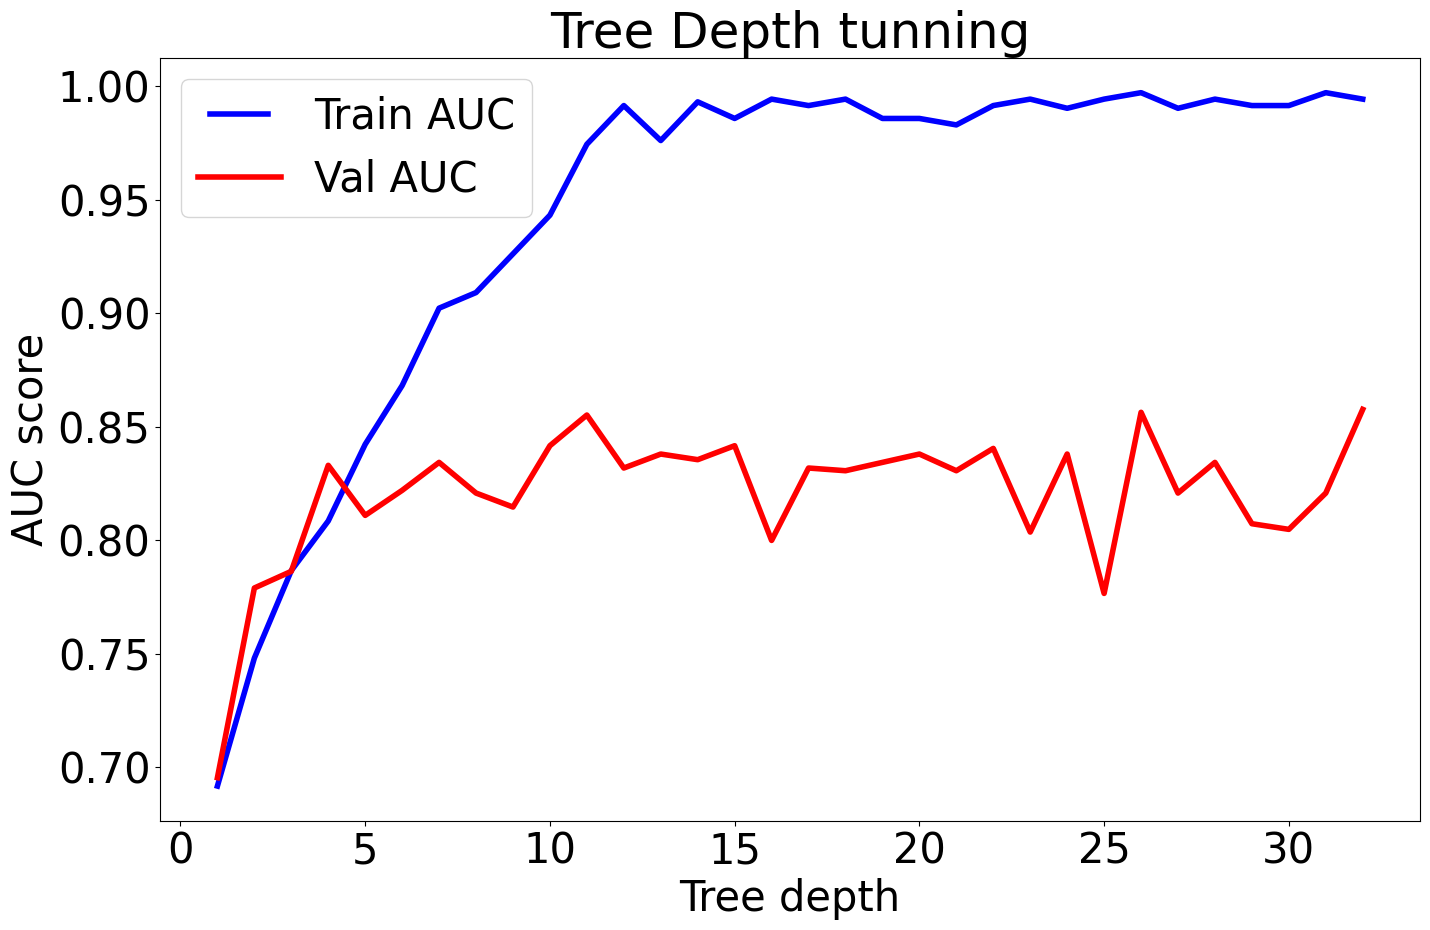

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=int(max_depth), n_jobs=-1, n_estimators=20)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
   roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_val)
   false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_val, y_pred)
   roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
import matplotlib
matplotlib.rcParams.update({'font.size': 30})
matplotlib.rcParams['figure.figsize'] = 15, 10
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC', linewidth=4)
line2, = plt.plot(max_depths, test_results, 'r', label='Val AUC', linewidth=4)
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.title('Tree Depth tunning')
plt.tight_layout()
plt.savefig('Tree_depth_tunning.png',dpi=400)
plt.show()

### n_estimators

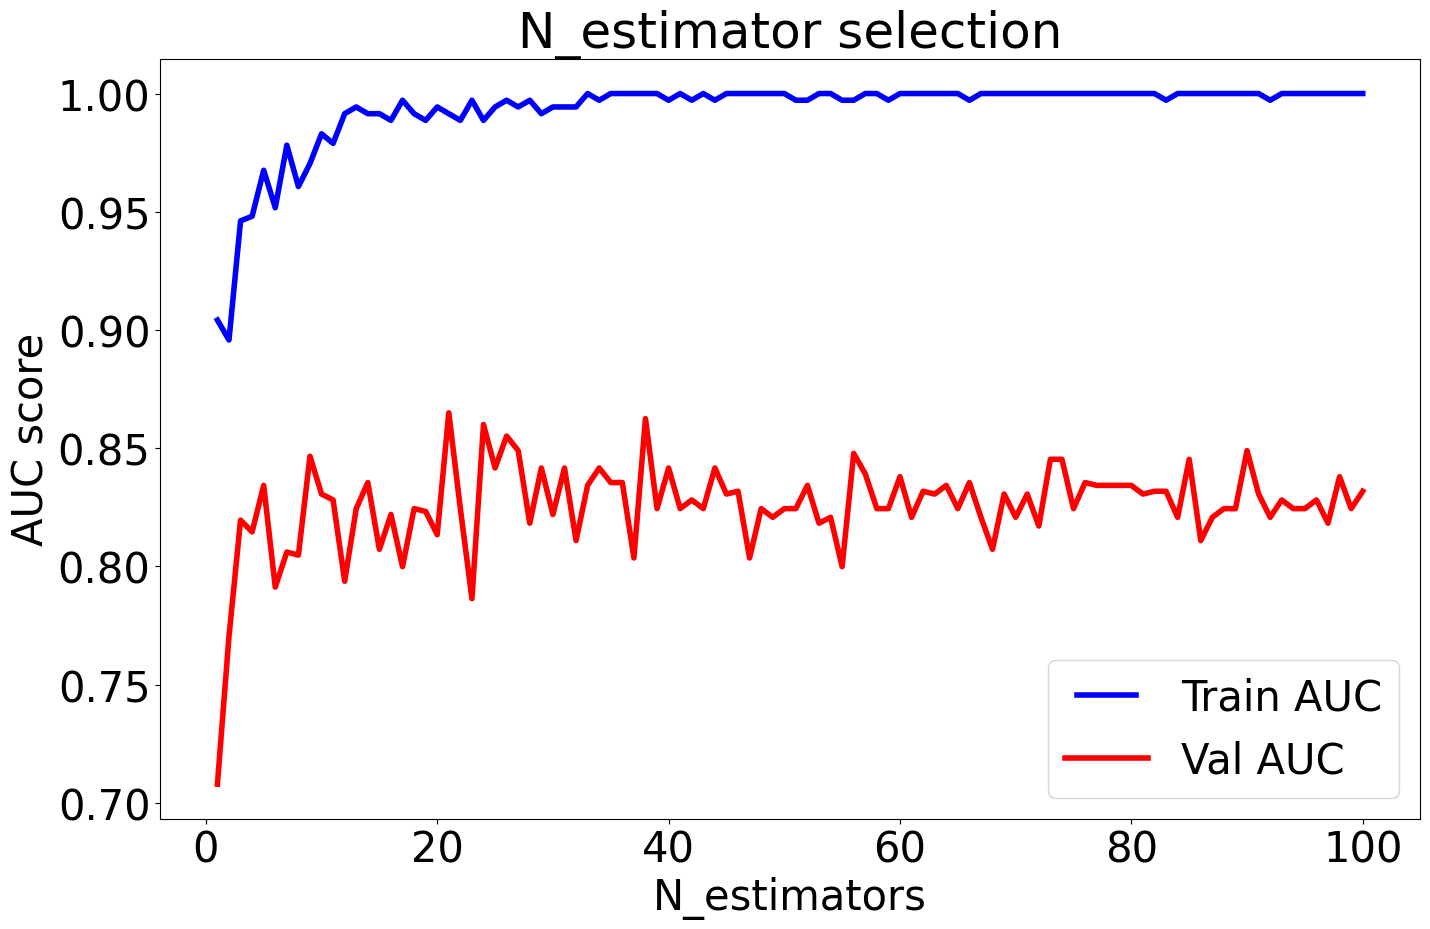

In [33]:
start=1
nest=np.linspace(1,100,100,dtype=int)
train_results = []
test_results = []
for n_estimators in nest:
   rf = RandomForestClassifier(max_depth=15, n_estimators=n_estimators)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
   roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_val)
   false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_val, y_pred)
   roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
import matplotlib
matplotlib.rcParams.update({'font.size': 30})
matplotlib.rcParams['figure.figsize'] = 15, 10
line1, = plt.plot(nest, train_results, 'b', label='Train AUC',linewidth=4)
line2, = plt.plot(nest, test_results, 'r', label='Val AUC',linewidth=4)
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('N_estimators')
plt.title('N_estimator selection')
plt.tight_layout()
plt.savefig('n_estimator.png',dpi=400)
plt.show()

In [35]:
from sklearn.ensemble import RandomForestClassifier
forest_classifier = RandomForestClassifier(
    bootstrap=True, class_weight=None, criterion='gini',
    max_depth=15, max_features='sqrt', max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1, min_samples_split=2,
    min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
    oob_score=False, random_state=None, verbose=0,
    warm_start=False
    )
forest_classifier.fit(x_train, y_train)
print(forest_classifier.feature_importances_)
pred_label_train = forest_classifier.predict(x_train)
pred_label_val = forest_classifier.predict(x_val)
pred_label_test = forest_classifier.predict(x_test)

[0.16861631 0.08146301 0.13323898 0.07348656 0.21658157 0.1679022
 0.15871136]


In [36]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_train, pred_label_train))
print(metrics.confusion_matrix(y_train, pred_label_train))
print(metrics.cohen_kappa_score(y_train, pred_label_train))
print(metrics.roc_auc_score(y_train, pred_label_train))

print("Accuracy:",metrics.accuracy_score(y_val, pred_label_val))
print(metrics.confusion_matrix(y_val, pred_label_val))
print(metrics.cohen_kappa_score(y_val, pred_label_val))
print(metrics.roc_auc_score(y_val, pred_label_val))

print("Accuracy:",metrics.accuracy_score(y_test, pred_label_test))
print(metrics.confusion_matrix(y_test, pred_label_test))
print(metrics.cohen_kappa_score(y_test, pred_label_test))
print(metrics.roc_auc_score(y_test, pred_label_test))

Accuracy: 0.9949324324324325
[[416   0]
 [  3 173]]
0.9878115735148787
0.9914772727272727
Accuracy: 0.8786127167630058
[[126  10]
 [ 11  26]]
0.6354239839438033
0.8145866454689984
Accuracy: 0.8555555555555555
[[61  1]
 [12 16]]
0.6223369916074888
0.7776497695852534


Feature ranking:
1. feature 4 (0.216582)
2. feature 0 (0.168616)
3. feature 5 (0.167902)
4. feature 6 (0.158711)
5. feature 2 (0.133239)
6. feature 1 (0.081463)
7. feature 3 (0.073487)


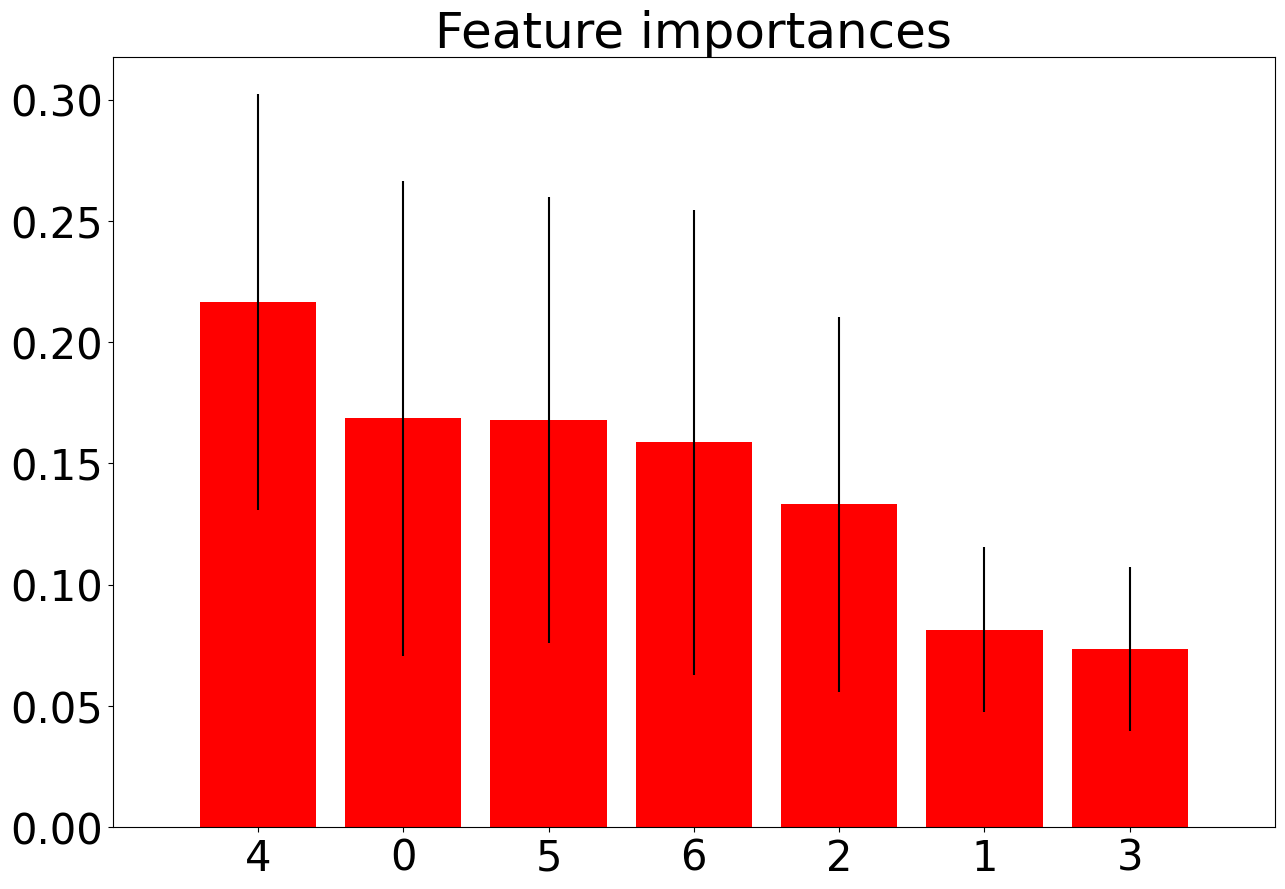

In [37]:
importances = forest_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.savefig('feature_importance',dpi=400)
plt.show()


In [38]:
# fit a logistic regression model to the data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs')
model.fit(x_train, y_train)
# make predictions
predicted = model.predict(x_val)
# summarize the fit of the model
#print(metrics.classification_report(val_label, predicted))
print("Accuracy:",metrics.accuracy_score(y_val, predicted))
print(metrics.confusion_matrix(y_val, predicted))
print(metrics.cohen_kappa_score(y_val, predicted))
print(metrics.roc_auc_score(y_val, predicted))

Accuracy: 0.8786127167630058
[[131   5]
 [ 16  21]]
0.5952089136490251
0.7654014308426074


In [39]:
from sklearn.svm import OneClassSVM
clf = OneClassSVM(gamma='scale', kernel='poly')
clf.fit(x_train, y_train)
pred_OneclassSVM = clf.predict(x_val)
print(np.sum(pred_OneclassSVM==1))
pred_OneclassSVM[pred_OneclassSVM==-1]=0
print("Accuracy:",metrics.accuracy_score(y_val, predicted))
print(metrics.confusion_matrix(y_val, pred_OneclassSVM))
print(metrics.cohen_kappa_score(y_val, pred_OneclassSVM))
print(metrics.accuracy_score(y_val, pred_OneclassSVM))
print(metrics.roc_auc_score(y_val, pred_OneclassSVM))

86
Accuracy: 0.8786127167630058
[[75 61]
 [12 25]]
0.15326852162252758
0.5780346820809249
0.6135731319554849


In [40]:
print((time[2]-time[1]).days)

0


In [41]:
from sklearn.ensemble import GradientBoostingClassifier
grad_tree= GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=10, random_state=10, loss='exponential').fit(x_train, y_train)
grad_tree_prediction = grad_tree.predict(x_val)
print("Accuracy:",metrics.accuracy_score(y_val, grad_tree_prediction))
print(metrics.confusion_matrix(y_val, grad_tree_prediction))
print(metrics.cohen_kappa_score(y_val, grad_tree_prediction))
print(metrics.roc_auc_score(y_val, grad_tree_prediction))

Accuracy: 0.8786127167630058
[[124  12]
 [  9  28]]
0.6493581700608049
0.8342607313195548


# Predicting time to eruption from a random forest regressor
## Fitting a random forest model


### trying to estimate max depth

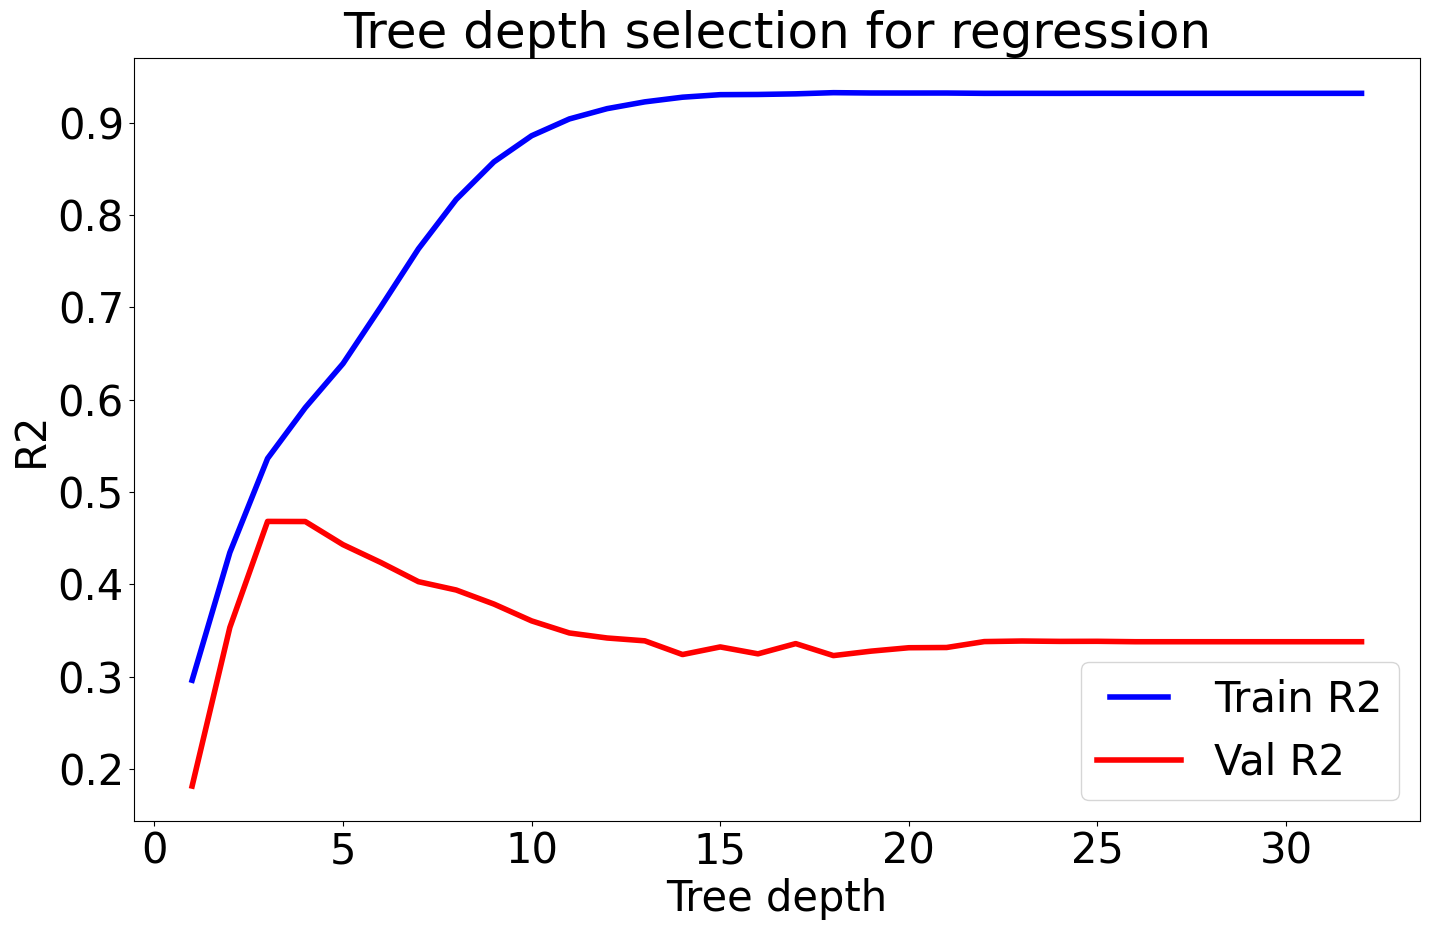

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestRegressor(max_depth=int(max_depth), random_state=0, n_estimators=50)
   rf.fit(x_train, rift_zone_time_to_eruption_train)
   train_pred = rf.predict(x_train)
   r2_train = metrics.r2_score(rift_zone_time_to_eruption_train, train_pred)
   train_results.append(r2_train)
   val_pred = rf.predict(x_val)
   r2_val = metrics.r2_score(rift_zone_time_to_eruption_val, val_pred)
   test_results.append(r2_val)
from matplotlib.legend_handler import HandlerLine2D
import matplotlib
matplotlib.rcParams.update({'font.size': 30})
matplotlib.rcParams['figure.figsize'] = 15, 10
line1, = plt.plot(max_depths, train_results, 'b', label='Train R2',linewidth=4)
line2, = plt.plot(max_depths, test_results, 'r', label='Val R2',linewidth=4)
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("R2")
plt.xlabel("Tree depth")
plt.title('Tree depth selection for regression')
plt.tight_layout()
plt.savefig('depth_tree_regression.png',dpi=400)
plt.show()

### trying to estimate n_estimators

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
RF_regr = RandomForestRegressor(max_depth=15, random_state=0, n_estimators=50)
RF_regr.fit(x_train, rift_zone_time_to_eruption_train)

,n_estimators,50
,criterion,'squared_error'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Predicting for train, val and test cases on optmized model

In [45]:
TTE_RF_pred_train = RF_regr.predict(x_train)
TTE_RF_pred_val = RF_regr.predict(x_val)
TTE_RF_pred_test = RF_regr.predict(x_test)

Printing metrics for the three datasets

In [46]:
print("Training data")
print(metrics.mean_squared_error( rift_zone_time_to_eruption_train, TTE_RF_pred_train))
print(metrics.r2_score( rift_zone_time_to_eruption_train,TTE_RF_pred_train,))
print("Val data")
print(metrics.mean_squared_error(rift_zone_time_to_eruption_val, TTE_RF_pred_val))
print(metrics.r2_score( rift_zone_time_to_eruption_val,TTE_RF_pred_val))
print("Test data")
print(metrics.mean_squared_error(rift_zone_time_to_eruption_test, TTE_RF_pred_test))
print(metrics.r2_score( rift_zone_time_to_eruption_test,TTE_RF_pred_test))

Training data
0.07343440983320662
0.9303505059008345
Val data
0.5659708180313028
0.33228182762217506
Test data
0.4303336413840825
0.5338349676331331


C:\Users\hario\AppData\Local\Temp\ipykernel_15272\1565882960.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(rift_zone_time_to_eruption_test, hist=False, color="r", label="Actual Value",kde_kws={"color": "r", "lw": 6, "label": "KDE"})
C:\Users\hario\AppData\Local\Temp\ipykernel_15272\1565882960.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see

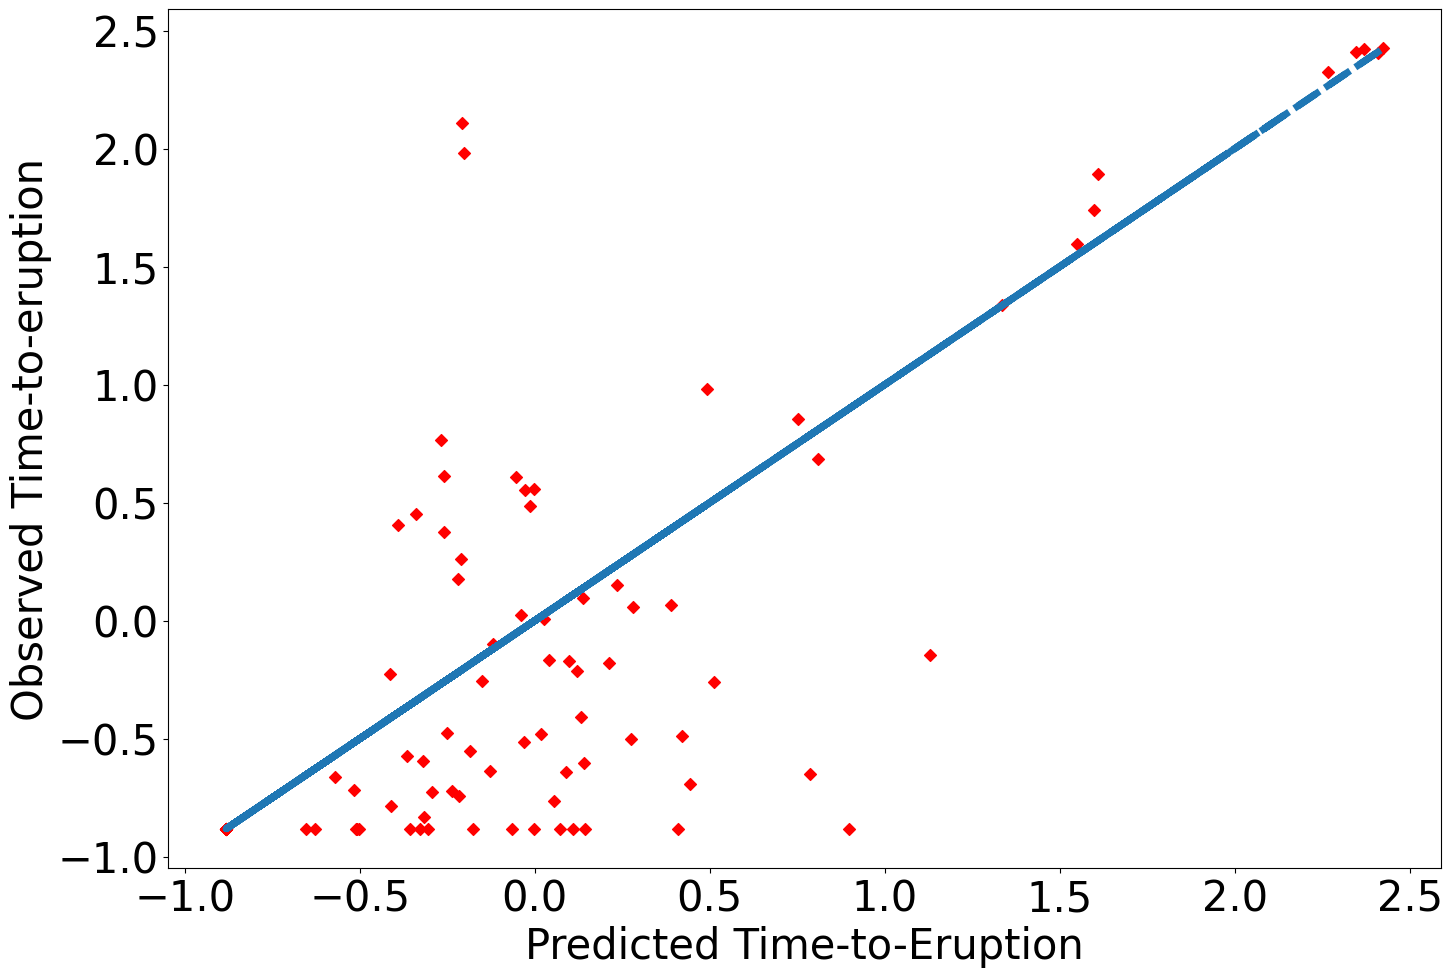

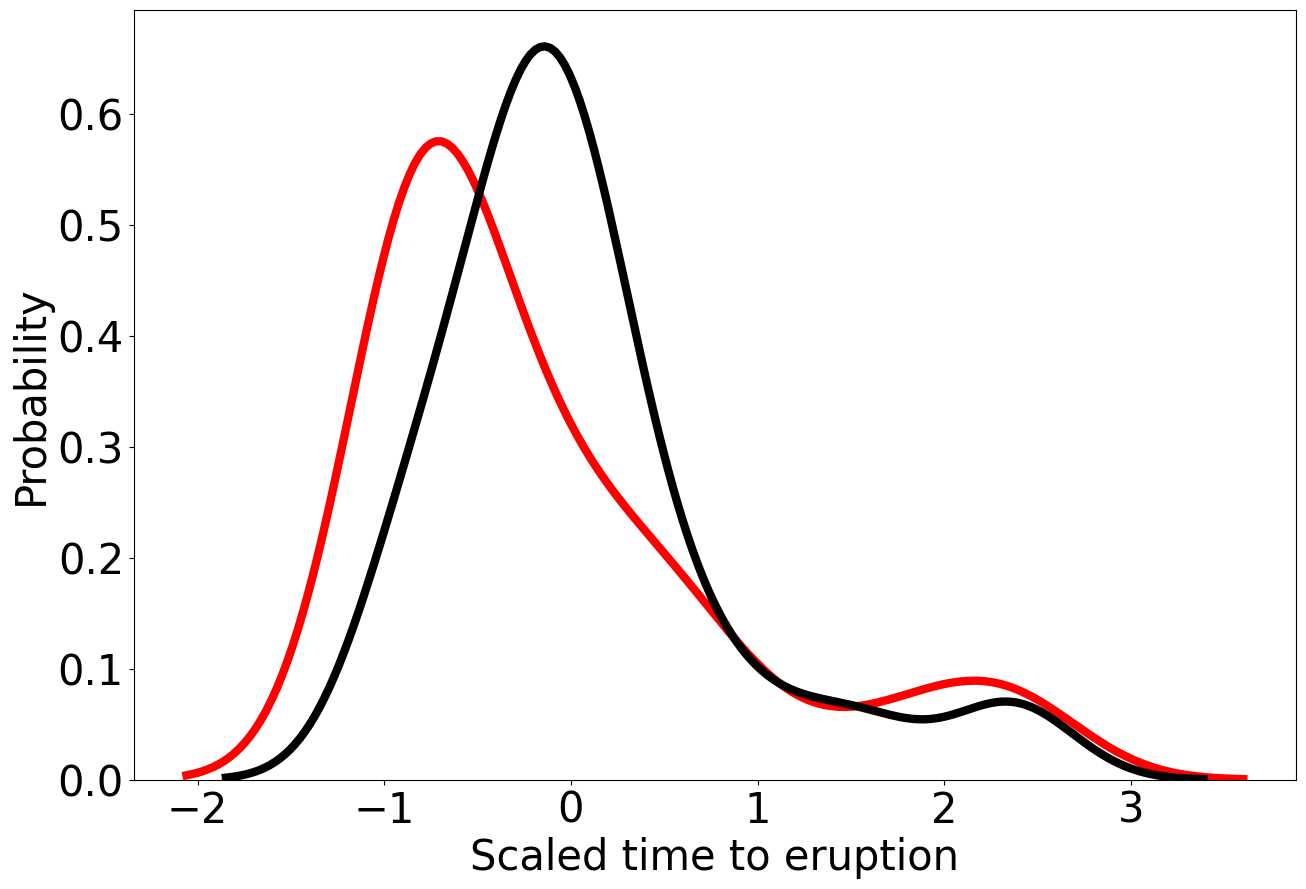

In [55]:
import seaborn as sns

plt.plot()
plt.tight_layout()
plt.plot(rift_zone_time_to_eruption_test, rift_zone_time_to_eruption_test, linestyle='dashed', linewidth=5)
plt.scatter(TTE_RF_pred_test,rift_zone_time_to_eruption_test, marker="D", color='r')
plt.ylabel("Observed Time-to-eruption")
plt.xlabel("Predicted Time-to-Eruption")
matplotlib.rcParams.update({'font.size': 30})
matplotlib.rcParams['figure.figsize'] = 15, 10
plt.savefig('RF_resgression_test.png',dpi=400)

plt.figure()
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 30})
matplotlib.rcParams['figure.figsize'] = 15, 10
ax1 = sns.distplot(rift_zone_time_to_eruption_test, hist=False, color="r", label="Actual Value",kde_kws={"color": "r", "lw": 6, "label": "KDE"})
sns.distplot(TTE_RF_pred_test, hist=False, color="b", label="Fitted Values" , ax=ax1,kde_kws={"color": "k", "lw": 6, "label": "KDE"})
plt.ylabel("Probability")
plt.xlabel("Scaled time to eruption")
plt.savefig('hist_test',dpi=400)



# Trial and error: SVM and gradient boosting 

0.8093874778258628
0.045104959087322594


C:\Users\hario\AppData\Local\Temp\ipykernel_15272\249504787.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(rift_zone_time_to_eruption_val, hist=False, color="r", label="Actual Value")
C:\Users\hario\AppData\Local\Temp\ipykernel_15272\249504787.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad

<Axes: ylabel='Density'>

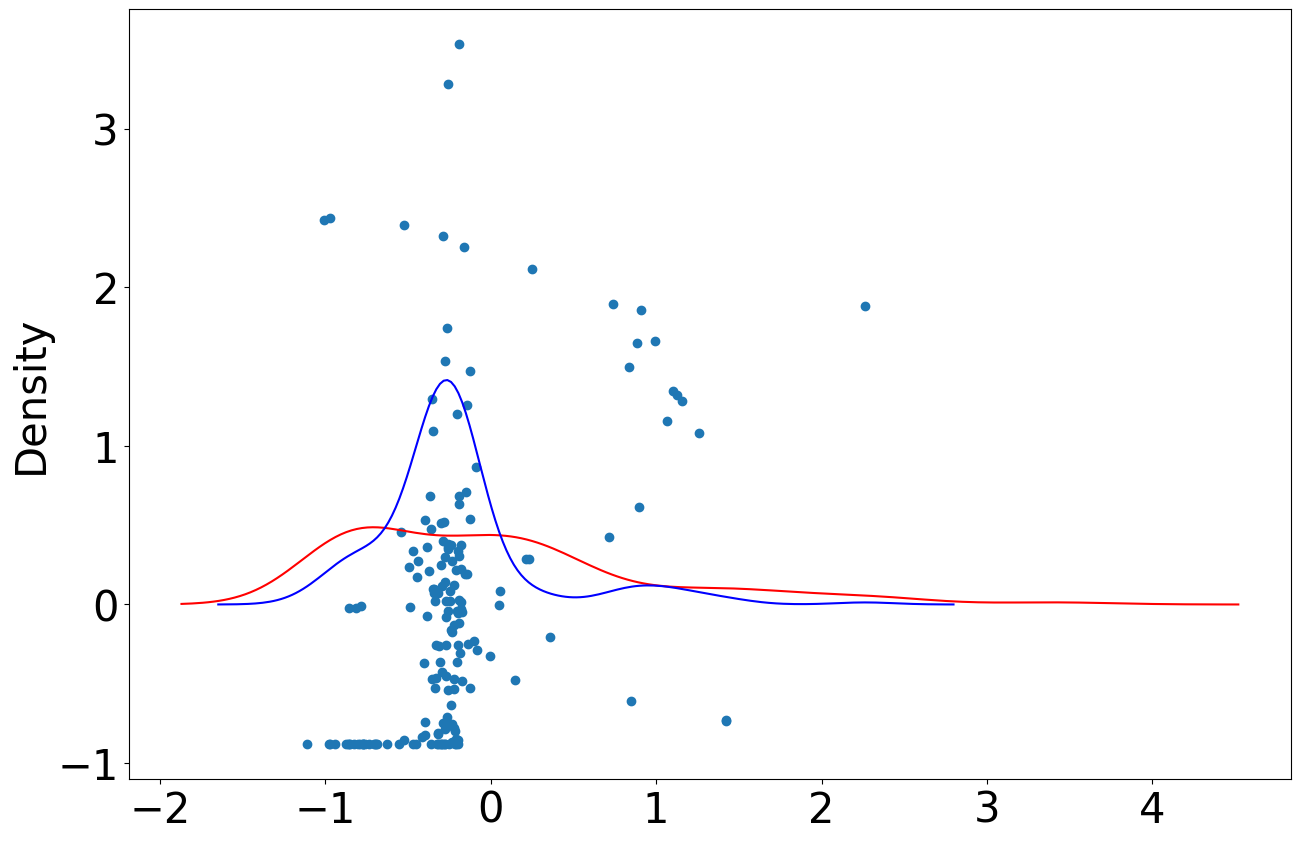

In [56]:
from sklearn import svm
SVM_TTE= svm.SVR(gamma = 'scale', kernel='linear')
SVM_TTE.fit(x_train, rift_zone_time_to_eruption_train)
svm_pred =SVM_TTE.predict(x_val)
print(metrics.mean_squared_error(rift_zone_time_to_eruption_val, svm_pred))
print(metrics.r2_score( rift_zone_time_to_eruption_val, svm_pred, ))
#plt.plot(rift_zone_time_to_eruption_val, rift_zone_time_to_eruption_val, linestyle='solid')
plt.scatter(svm_pred,rift_zone_time_to_eruption_val)

import seaborn as sns

ax1 = sns.distplot(rift_zone_time_to_eruption_val, hist=False, color="r", label="Actual Value")
sns.distplot(svm_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)

(array([1.42955527e-06, 2.99150781e-07, 3.42724564e-07, 3.38534778e-07,
        3.78756731e-07, 5.12829911e-07, 3.65349413e-07, 2.48873339e-07,
        2.48873339e-07, 1.84350621e-07, 1.75971048e-07, 1.16476074e-07,
        7.12263765e-08, 7.54161633e-08, 6.95504617e-08, 7.62541207e-08,
        6.78745470e-08, 6.45227175e-08, 5.86570159e-08, 6.28468028e-08,
        6.36847601e-08, 6.28468028e-08, 6.28468028e-08, 1.08934458e-08,
        7.54161633e-09, 4.18978685e-09, 4.18978685e-09, 1.08934458e-08,
        9.21753107e-09, 1.00554884e-08]),
 array([      0. ,  184021.3,  368042.6,  552063.9,  736085.2,  920106.5,
        1104127.8, 1288149.1, 1472170.4, 1656191.7, 1840213. , 2024234.3,
        2208255.6, 2392276.9, 2576298.2, 2760319.5, 2944340.8, 3128362.1,
        3312383.4, 3496404.7, 3680426. , 3864447.3, 4048468.6, 4232489.9,
        4416511.2, 4600532.5, 4784553.8, 4968575.1, 5152596.4, 5336617.7,
        5520639. ]),
 <BarContainer object of 30 artists>)

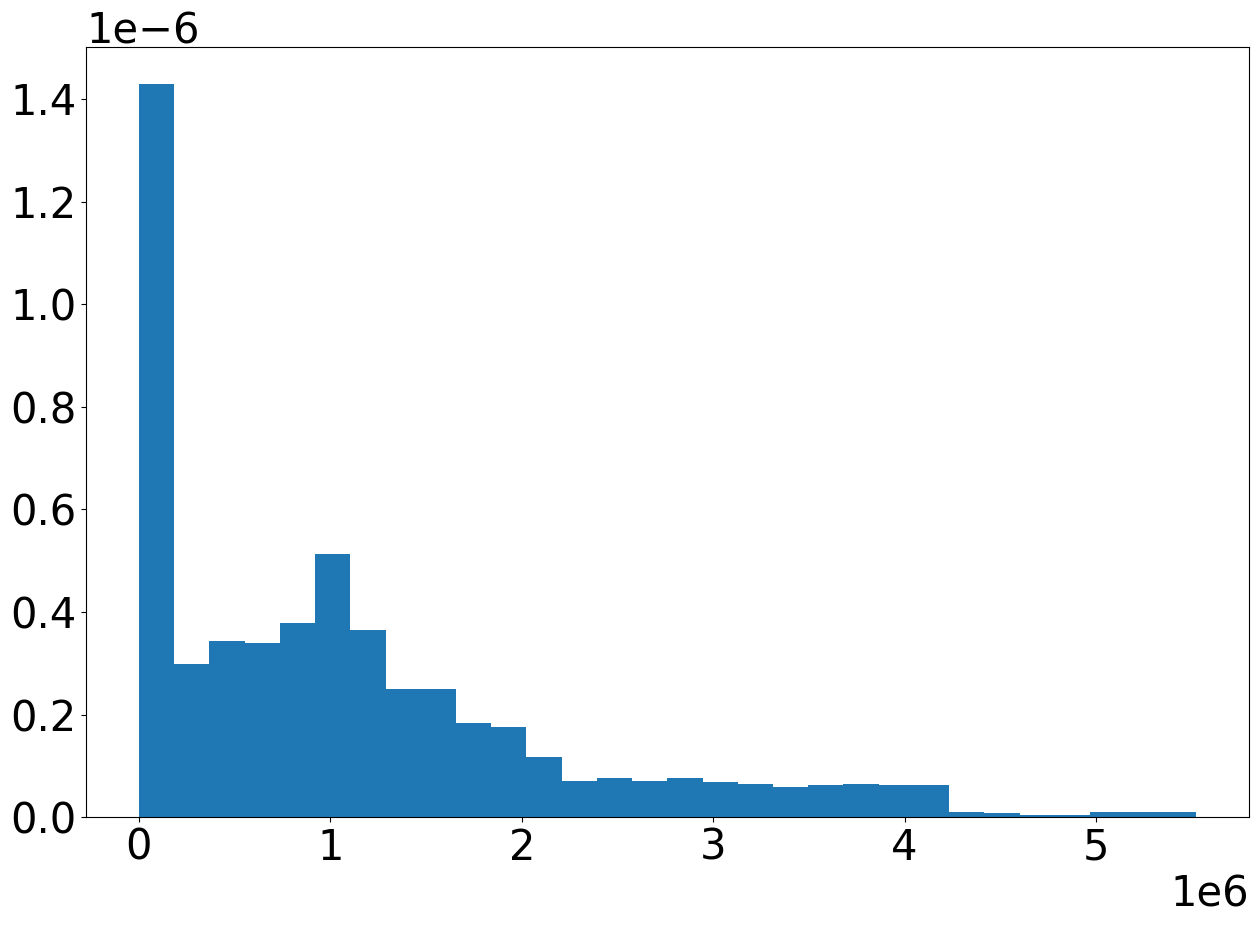

In [49]:
time_to_eruption_check = util.GetTimeToEruption(time,p)
plt.hist(time_to_eruption_check, density=True, bins=30)


0.452664155154628


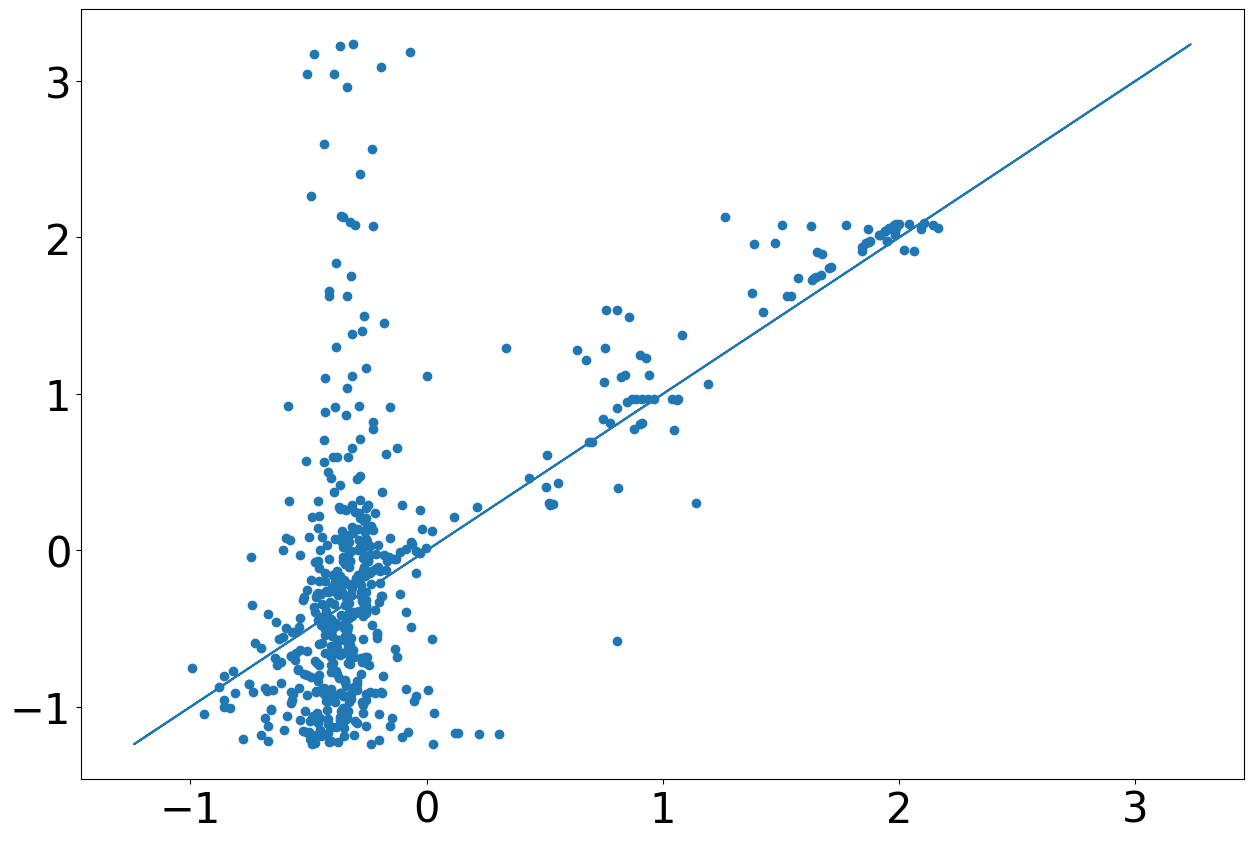

In [57]:
from sklearn import preprocessing
rift_zone_time_to_eruption_check = time_to_eruption_check[inds]
rift_zone_data_check = preprocessing.scale(rift_zone_data[rift_zone_time_to_eruption_check > 86400])
new_TTE = preprocessing.scale(rift_zone_time_to_eruption_check[rift_zone_time_to_eruption_check > 86400])
np.shape(rift_zone_data_check)
np.shape(new_TTE)
SVM_TTE = svm.SVR(gamma='auto')
SVM_TTE.fit(rift_zone_data_check, new_TTE)
svm_pred = SVM_TTE.predict(rift_zone_data_check)
plt.plot(new_TTE, new_TTE, linestyle='solid')
plt.scatter(svm_pred, new_TTE)
print(metrics.r2_score(new_TTE, svm_pred))

(array([0.1027388 , 0.20547761, 0.51369401, 0.46232461, 0.1027388 ,
        0.46232461, 1.13012683, 2.82531707, 1.69519024, 0.20547761,
        0.1027388 , 0.1541082 , 0.0513694 , 0.0513694 , 0.        ,
        0.        , 0.1027388 , 0.25684701, 0.0513694 , 0.1541082 ,
        0.0513694 , 0.0513694 , 0.1027388 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.0513694 ]),
 array([-1.11243976, -0.99991467, -0.88738957, -0.77486448, -0.66233938,
        -0.54981428, -0.43728919, -0.32476409, -0.21223899, -0.0997139 ,
         0.0128112 ,  0.12533629,  0.23786139,  0.35038649,  0.46291158,
         0.57543668,  0.68796177,  0.80048687,  0.91301197,  1.02553706,
         1.13806216,  1.25058726,  1.36311235,  1.47563745,  1.58816254,
         1.70068764,  1.81321274,  1.92573783,  2.03826293,  2.15078802,
         2.26331312]),
 <BarContainer object of 30 artists>)

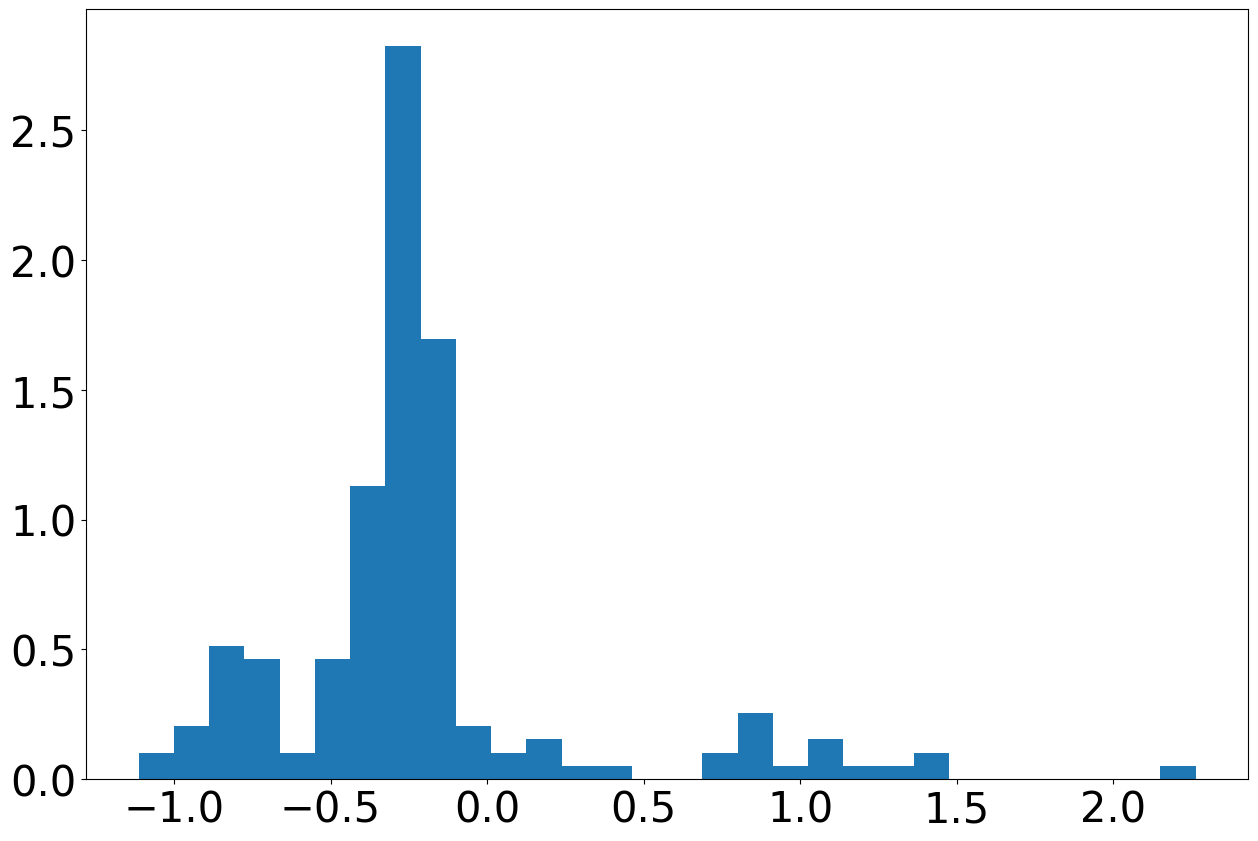

In [51]:
plt.hist(svm_pred, density=True, bins=30)


In [52]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor()
clf.fit(x_train,rift_zone_time_to_eruption_train)
boost_pred=clf.predict(x_test)

0.5845751539050317


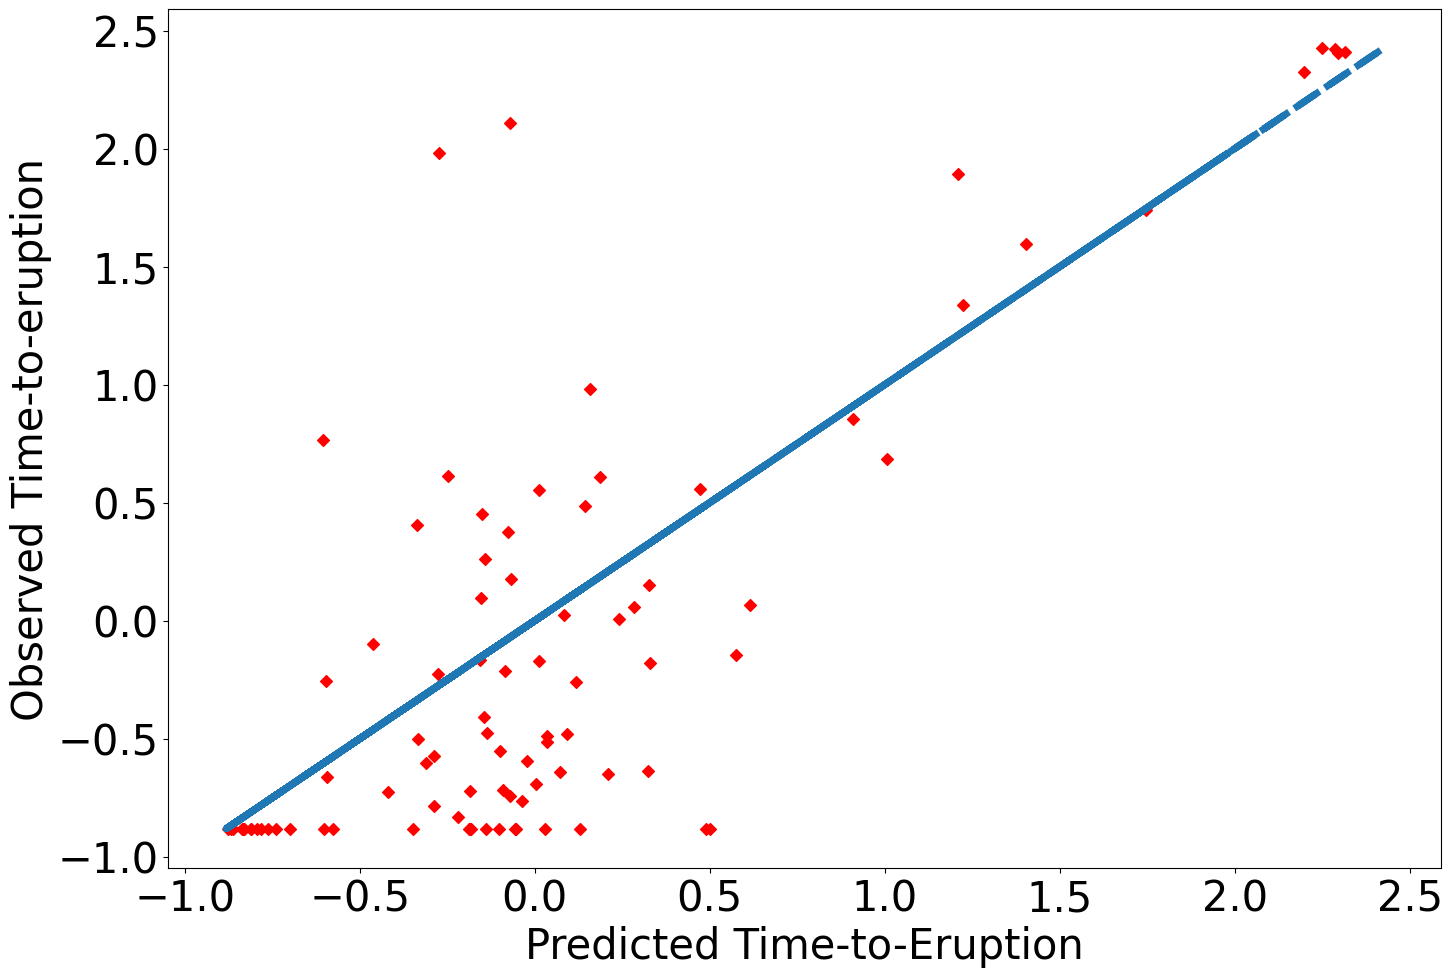

In [53]:

plt.plot()
plt.tight_layout()
plt.plot(rift_zone_time_to_eruption_test, rift_zone_time_to_eruption_test, linestyle='dashed', linewidth=5)
plt.scatter(boost_pred,rift_zone_time_to_eruption_test, marker="D", color='r')
plt.ylabel("Observed Time-to-eruption")
plt.xlabel("Predicted Time-to-Eruption")
matplotlib.rcParams.update({'font.size': 30})
matplotlib.rcParams['figure.figsize'] = 15, 10
plt.savefig('RF_resgression_test.png',dpi=400)
print(metrics.r2_score( rift_zone_time_to_eruption_test,boost_pred))
